In [1]:
import pandas as pd

In [2]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

# set up plotly defaults
pio.renderers.default = "plotly_mimetype+svg"
pio.templates["book"] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350,
        height=250,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+book"

def margin(fig, **kwargs):
    """Set margins for a plotly figure"""
    return fig.update_layout(margin=kwargs)

In [3]:
# Prep sqlite database
#import sqlalchemy
# db = sqlalchemy.create_engine('sqlite:///babynames.db')

# csvs = [('babynames.csv', 'baby'), ('nyt_names.csv', 'nyt')]

# for csv, name in csvs:
#     df = pd.read_csv(csv)
#     df.to_sql(name, db, index=False, if_exists='replace')

# Subsetting

This section introduces operations for taking subsets of relations. When data
scientists begin working with a relation, they often want to subset the specific
data that they plan to use. For example, a data scientist can *slice* out the
ten relevant features from a relation with hundreds of columns. Or, they can
*filter* a relation to remove rows with incomplete data. For the rest of this
chapter, we'll introduce relation operations using a dataset of baby names.

To work with relations, we'll introduce a domain-specific programming language
called **SQL** (Structured Query Language). We commonly pronounce "SQL" like
"sequel" instead of spelling out the acronym. SQL is a specialized language for
working with relations---as such, SQL has its own syntax that makes it easier
to write programs that operate on relational data.

## About the Data

There's a 2021 New York Times article that talks about Prince Harry and
Meghan's unique choice for their new baby daughter's name: Lilibet
{cite}`williamsLilith2021`. The article has an interview with Pamela Redmond,
an expert on baby names, who talks about interesting trends in how people name
their kids. For example, she says that names that start with the letter "L"
have become very popular in recent years, while names that start with the
letter "J" were most popular in the 1970s and 1980s. Are these claims reflected
in data? We can use SQL to find out.

In this chapter, we'll use SQL queries within Python programs. This illustrates
a common workflow---data scientists often process and subset data in SQL before
loading the data into Python for further analysis. SQL databases make it easier
to work with large amounts of data compared to `pandas` programs. However,
loading data into `pandas` makes it easier to visualize the data and build
statistical models.

So, in this chapter we'll use the `pandas.read_sql` function which runs a SQL
query and stores the output in a dataframe. Using this function requires some
setup. We start by importing the `pandas` and `sqlalchemy` Python packages.

In [4]:
import pandas as pd
import sqlalchemy

Our database is stored in a file called `babynames.db`. This file is a SQLite
database {cite}`SQLite`, so we'll set up a `sqlalchemy` object that can process
this format.

In [7]:
db = sqlalchemy.create_engine('sqlite:///data/babynames.db')

:::{note}

SQL is a programming language that is implemented differently across database
systems. In this book, we use SQLite, one popular database system. Other
systems make different tradeoffs that are useful for different domains. For
instance, PostgreSQL and MySQL are systems that are useful for large web
applications where many end users are writing data at the same time. 

To make matters more complicated, each SQL system has slight differences. In
this book, we'll rely on core parts of SQL syntax that are unlikely to change
across implementations. While we won't go over other systems in detail, we'll
point out where different SQL systems may differ in capabilities. 

:::

Now, we can use `pd.read_sql` to run SQL queries on this database. This
database has two relations: `baby` and `nyt`. Here's a simple example that
reads in the entire `baby` relation.

In [8]:
# SQL query saved in a Python string
query='''
SELECT * 
FROM baby;
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
...,...,...,...,...
2020717,Ula,F,5,1880
2020718,Vannie,F,5,1880
2020719,Verona,F,5,1880
2020720,Vertie,F,5,1880


The text inside the `query` variable contains SQL code. `SELECT` and `FROM` are
SQL keywords. We read the query above like:

```sql
SELECT *    -- Get all the columns...
FROM baby;  -- ...from the baby relation
```

The data in the `baby` relation comes from the US Social Security department,
which records the baby name and birth sex for birth certificate purposes. They
make the baby names data available on their website {cite}`babynamesData`.

The Social Security website has a page that describes the data in more detail
([link](https://www.ssa.gov/oact/babynames/background.html)). We won't go
in-depth in this chapter about the data's limitations, but we'll point out
this relevant quote from the website:

> All names are from Social Security card applications for births that occurred
> in the United States after 1879. Note that many people born before 1937 never
> applied for a Social Security card, so their names are not included in our
> data. For others who did apply, our records may not show the place of birth,
> and again their names are not included in our data.
>
> All data are from a 100% sample of our records on Social Security card
> applications as of March 2021.

## What's a Relation?

Let's examine the `baby` relation in more detail. A relation has rows and
columns. Every column has a label, as illustrated in
{numref}`fig:relation-labels`. Unlike dataframes, however, individual rows in a
relation don't have labels. Also, unlike dataframes, rows of a relation aren't
ordered.

```{figure} figures/relation-labels.svg
---
name: fig:relation-labels
alt: relation-labels
---
The `baby` relation has labels for columns (boxed).
```

Relations have a long history. More formal treatments of relations use the term
"tuple" to refer to the rows of a relation, and "attribute" to refer to the
columns. There is also a rigorous way to define data operations using
relational algebra, which is derived from mathematical set algebra. Interested
data scientists can find a more in-depth treatment of relations in books on
database systems such as the one by Garcia-Molina, Ullman, and Widom
{cite}`garcia-molinaDatabase2008`.

## Slicing

*Slicing* is an operation that creates a new relation by taking a subset of
rows or columns out of another relation. Think about slicing a tomato---slices
can go both vertially and horizontally. To slice columns of a relation, we give
the `SELECT` statement the columns we want. 

In [11]:
query = '''
SELECT NAME
FROM baby;
'''
pd.read_sql(query, db)

,Name
0,Liam
1,Noah
2,Oliver
3,Elijah
4,William
...,...
2020717,Ula
2020718,Vannie
2020719,Verona
2020720,Vertie


In [12]:
query = '''
SELECT Name, Count
FROM baby;
'''
pd.read_sql(query, db)

,Name,Count
0,Liam,19659
1,Noah,18252
2,Oliver,14147
3,Elijah,13034
4,William,12541
...,...,...
2020717,Ula,5
2020718,Vannie,5
2020719,Verona,5
2020720,Vertie,5


To slice out a specific number of rows, use the `LIMIT` keyword:

In [13]:
query = '''
SELECT Name
FROM baby
LIMIT 10;
'''
pd.read_sql(query, db)

,Name
0,Liam
1,Noah
2,Oliver
3,Elijah
4,William
5,James
6,Benjamin
7,Lucas
8,Henry
9,Alexander


In sum, we use the `SELECT` and `LIMIT` keywords to slice columns and rows
of a relation.

## Filtering Rows
So far, we've shown how to use `SELECT` and `LIMIT` to slice columns and rows
of a relation. 

However, data scientists often want to *filter* rows---they want to take
subsets of rows using some criteria. Let's say you want to find the most
popular baby names in 2020. To do this, you can filter rows to keep only the
rows where the `Year` is 2020.

To filter a relation, use the `WHERE` keyword with a predicate:

In [19]:
query = '''
SELECT *
FROM baby
WHERE Year = 2020;
'''
pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
...,...,...,...,...
31265,Zykeria,F,5,2020
31266,Zylani,F,5,2020
31267,Zylynn,F,5,2020
31268,Zynique,F,5,2020


:::{warning}

Note that when comparing for equality, SQL uses a single equals sign:

```sql
SELECT *
FROM baby
WHERE Year = 2020;
--         ↑
--         Single equals sign
```

In Python, however, single equals signs are used for variable assignment. The
statement `Year = 2020` will assign the value `2020` to the variable `Year`. To
compare for equality, Python code uses double equals signs:

```python
# Assignment
my_year = 2021

# Comparison, which evaluates to False
my_year == 2020
```

:::

To add more predicates to the filter, use the `AND` and `OR` keywords. For
instance, to find the names that have more than 10000 babies in either 2020 or
2019, we write:

In [21]:
query = '''
SELECT *
FROM baby
WHERE Count > 10000
    AND (Year = 2020 
         OR Year = 2019);
'''
pd.read_sql(query, db)
    

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
3,Elijah,M,13034,2020
4,William,M,12541,2020
5,James,M,12250,2020
6,Benjamin,M,12136,2020
7,Lucas,M,11281,2020
8,Henry,M,10705,2020
9,Alexander,M,10151,2020


Finally, to find the ten most common names in 2020, we can sort the dataframe
by `Count` in descending order using the `ORDER BY` keyword with the `DESC`
option (short for DESCending).

In [23]:
query = '''
SELECT *
FROM baby
WHERE Year = 2020
ORDER BY Count DESC
LIMIT 10
'''
pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Emma,F,15581,2020
3,Oliver,M,14147,2020
4,Ava,F,13084,2020
5,Elijah,M,13034,2020
6,Charlotte,F,13003,2020
7,Sophia,F,12976,2020
8,Amelia,F,12704,2020
9,William,M,12541,2020


We see that Liam, Noah, and Emma were the most popular baby names in 2020.

## Example: How recently has Luna become a popular name?

The New York Times article mentions that the name "Luna" was almost nonexistent
before 2000 but has since grown to become a very popular name for girls.
When exactly did Luna become popular?
We can check this using slicing and filtering.
When approaching a data manipulation
task, we recommend breaking the problem down into smaller steps. For
example, we could think:

1. Filter: keep only rows with `'Luna'` in the `Name` column, and `'F'` in the
   `Sex` column.
1. Slice: keep the `Count` and `Year` columns.

Now, it's a matter of translating each step into code.

In [30]:
query = '''
SELECT *
FROM baby
WHERE Name = 'Luna' 
    AND Sex = 'F'
'''
luna = pd.read_sql(query, db)
luna

,Name,Sex,Count,Year
0,Luna,F,7770,2020
1,Luna,F,7772,2019
2,Luna,F,6929,2018
3,Luna,F,5351,2017
4,Luna,F,3677,2016
...,...,...,...,...
123,Luna,F,15,1885
124,Luna,F,18,1884
125,Luna,F,17,1883
126,Luna,F,18,1881


`pd.read_sql` returns a `pandas.DataFrame` object, which we can use to make
a plot.  This illustrates a common workflow: process the data using SQL, load
it into a `pandas` dataframe, then visualize the results.

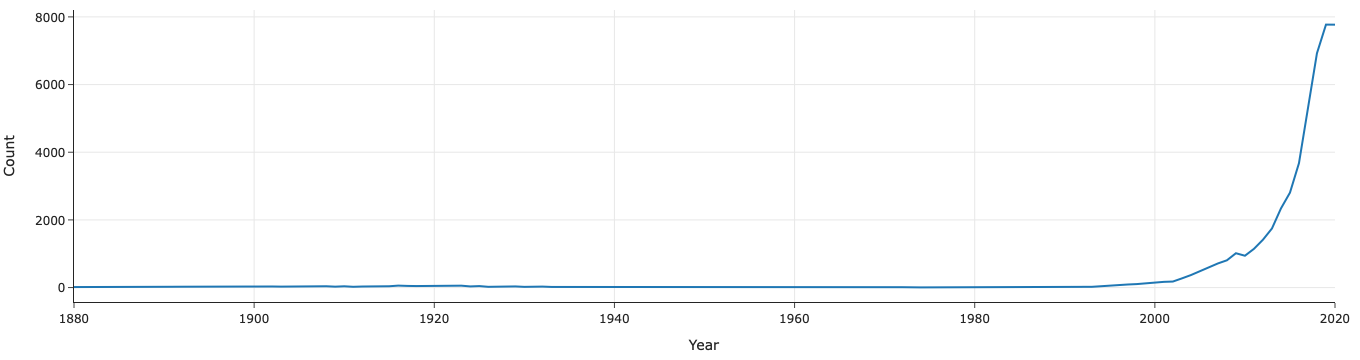

In [31]:
px.line(luna, x="Year", y="Count", width=350, height=250)

It's just as the article says. Luna wasn't popular at all until the year 2000
or so. Think about that---if someone tells you that their name is Luna, you can
take a pretty good guess at their age even without any other information about
them!

Just for fun, here's the same plot for the name Siri.

In [33]:
query = '''
SELECT *
FROM baby
WHERE Name = "Siri"
    AND Sex = "F"
'''
siri=pd.read_sql(query,db)
siri

,Name,Sex,Count,Year
0,Siri,F,10,2020
1,Siri,F,13,2019
2,Siri,F,20,2018
3,Siri,F,20,2017
4,Siri,F,24,2016
...,...,...,...,...
71,Siri,F,12,1949
72,Siri,F,7,1947
73,Siri,F,5,1946
74,Siri,F,6,1944


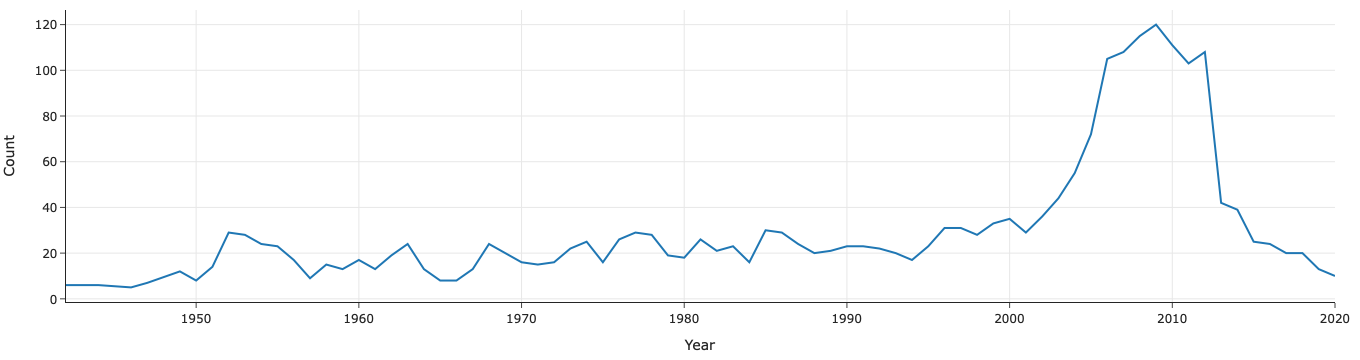

In [34]:
px.line(siri,x="Year",y="Count",width=350,height=250)

Why might the popularity have dropped so suddenly after 2010?
Well, Siri happens to be the
name of Apple's voice assistant and was introduced in 2011.
Let's draw a line for the year 2011 and take a look...

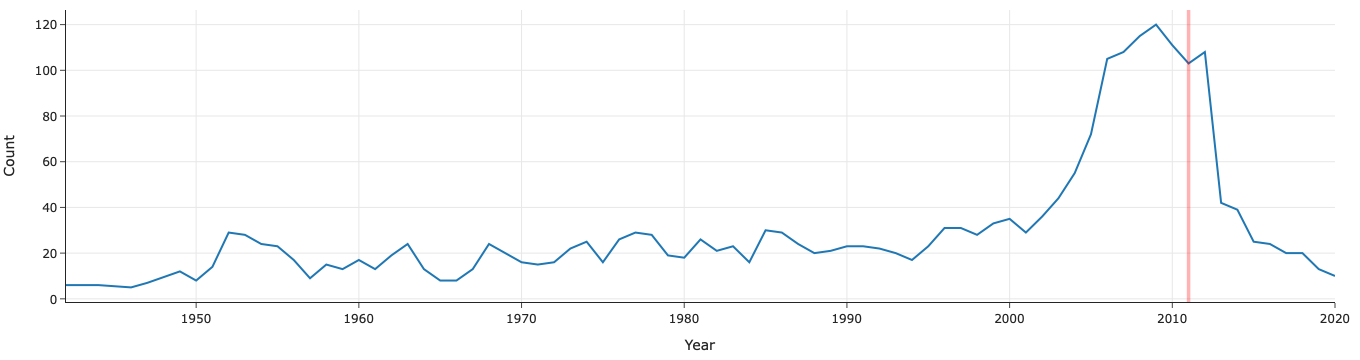

In [35]:
fig = px.line(siri, x='Year', y='Count', width=350, height=250)
fig.add_vline(x=2011, line_color='red', line_width=4)

It looks like parents don't want their kids to be confused when other
people say "Hey Siri" to their phones.

## Takeaways

This section introduces relations in SQL.
We've covered the common ways that data scientists subset relations---slicing
with column labels and filtering using a boolean condition.
In the next section, we explain how to aggregate rows together.